In [1]:
import matplotlib
import matplotlib.pyplot as plt
import random
import numpy as np
import datetime
import math

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.15.0


In [3]:
quartic_weights = [-0.5, 1, 0.7, 0.2, 1]
quartic_name = "-0.5x^4 + x^3 + 0.7x^2 + 0.2x + 1"

# Set training params
targetTrainSize = 1000
ratioOfTest = 0.1
totalGenSize = math.floor(targetTrainSize / (1 - ratioOfTest))
trainSize = math.floor(totalGenSize * (1 - ratioOfTest))
testSize = math.floor(totalGenSize * ratioOfTest)
noise_std = 0.5
epochs = 500

In [4]:
# define the ground truth function
def quartic_func(in_val, weights=quartic_weights):
    powers = np.array([4, 3, 2, 1])
    in_vals = np.array([in_val, in_val, in_val, in_val])

    out_val = np.sum( np.power(in_vals, powers) * (weights[:4]) ) + weights[-1]
    
    return out_val


def sample(n, domain_start=0, domain_end=1, noise_std=0.2, function=quartic_func, weights=quartic_weights):
    random.seed(2525)
    dom_arr = []
    range_arr = []

    for n in range(n-1):
        dom_val = (random.random() * (domain_end - domain_start)) + domain_start
        dom_val = dom_val + (random.gauss(0, noise_std))

        range_val = function(dom_val, weights)
        range_val = range_val + (random.gauss(0, noise_std))


        if ((dom_val < domain_end) and (dom_val >= domain_start)):
            dom_arr.append(dom_val)
            range_arr.append(range_val)

    return [dom_arr, range_arr]

[-0.5, 1, 0.7, 0.2, 1]


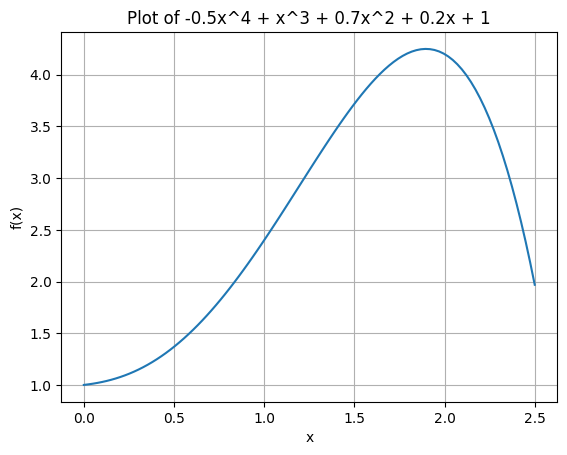

In [5]:
# plot the underlying quartic function and the generated samples
x = np.linspace(0, 2.5, 100)

def quartic_func_bulk(in_arr, weights=quartic_weights):
    y = map(quartic_func, in_arr, [weights]*len(in_arr))
    y = np.array(list(y))
    return y

plt.plot( x, quartic_func_bulk(x, quartic_weights) )
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Plot of ' + quartic_name)
plt.grid(True)
plt.xscale('linear')
print(quartic_weights)
plt.show()

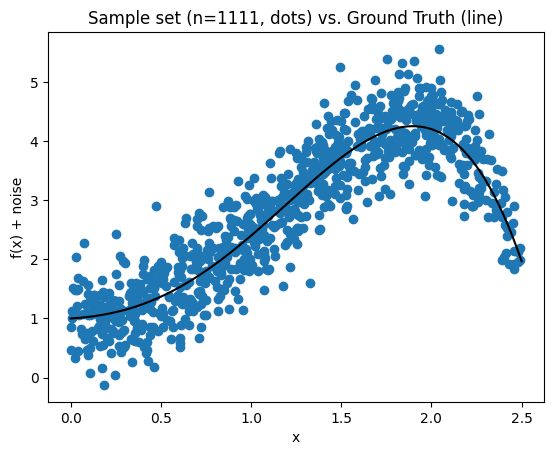

In [6]:
sampleset = sample(totalGenSize, domain_start=0, domain_end=2.5, noise_std=noise_std, function=quartic_func)
model_input = sampleset[0]
labels = sampleset[1]

plt.scatter( model_input, labels )
plt.plot( x, quartic_func_bulk(x, quartic_weights), color='black' )
plt.xlabel("x")
plt.ylabel("f(x) + noise")
plt.title("Sample set (n=" + str(totalGenSize) + ", dots) vs. Ground Truth (line)")

plt.show()

In [7]:
# make a training and test split
x_train, x_test , y_train , y_test = train_test_split(model_input, labels, test_size=0.1, random_state=42)
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

x_train = x_train.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

# print(x_train)
# print(y_train)

(834, 1)
(834, 1)
(93, 1)
(93, 1)


In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(500),
    tf.keras.layers.LeakyReLU(alpha=0.3),
    tf.keras.layers.Dense(500),
    tf.keras.layers.LeakyReLU(alpha=0.3),
    tf.keras.layers.Dense(1)
])

In [10]:
loss_fn = tf.keras.losses.MeanSquaredError(reduction="sum_over_batch_size")
# loss_fn = tf.keras.losses.MeanAbsolutePercentageError()

model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])

# tensorboard stuff
log_dir = "C:\\Users\\cokie\\Workspace\\TensorboardLogs\\CMI-PB\\CMI-PB_polytest00\\logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [11]:
model.fit(
    x_train,
    y_train,
    epochs=epochs,
    callbacks=[tensorboard_callback]
    )

Epoch 1/500

27/27 [==============================] - 1s 9ms/step - loss: 1.6020 - mean_absolute_percentage_error: 40.4758
Epoch 2/500
27/27 [==============================] - 0s 5ms/step - loss: 0.6833 - mean_absolute_percentage_error: 30.1115
Epoch 3/500
27/27 [==============================] - 0s 4ms/step - loss: 0.5968 - mean_absolute_percentage_error: 30.8247
Epoch 4/500
27/27 [==============================] - 0s 5ms/step - loss: 0.5007 - mean_absolute_percentage_error: 31.0629
Epoch 5/500
27/27 [==============================] - 0s 4ms/step - loss: 0.4987 - mean_absolute_percentage_error: 33.1234
Epoch 6/500
27/27 [==============================] - 0s 4ms/step - loss: 0.4952 - mean_absolute_percentage_error: 33.0868
Epoch 7/500
27/27 [==============================] - 0s 4ms/step - loss: 0.5097 - mean_absolute_percentage_error: 33.0492
Epoch 8/500
27/27 [==============================] - 0s 4ms/step - loss: 0.5142 - mean_absolute_percentage_error: 33.0713
Epoch 9/500
27/27 [====

In [12]:
predictions = model.predict(x_test)

# print(predictions)

3/3 [==============================] - 0s 2ms/step


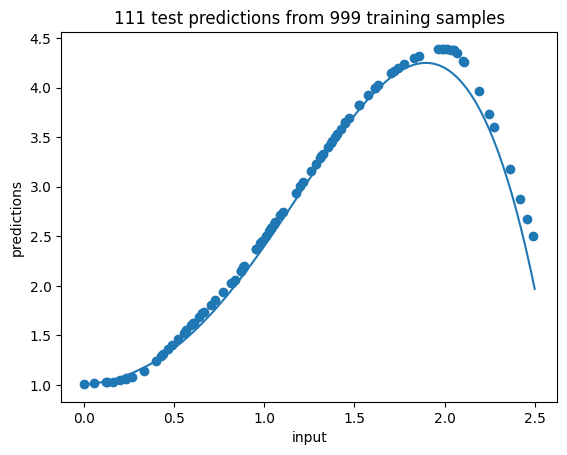

In [13]:
plt.plot( x, quartic_func_bulk(x, quartic_weights) )
plt.scatter( x_test, predictions )
plt.xlabel("input")
plt.ylabel("predictions")
plt.title(str(testSize) + " test predictions from " + str(trainSize) + " training samples")

plt.show()

In [14]:
%tensorboard --logdir log_dir

UsageError: Line magic function `%tensorboard` not found.


In [99]:
# plot accuracy over a range of training sample sizes
# for now, go from 1 to 1000 training samples
# train model once per sample size (may want to change this later to deal with stochasticity)

ratioOfTest = 0.1
noise_std = 0.5
epochs = 500

errors = []
min_trainSize = 5
max_trainSize = 1000
max_sampleSize = math.floor(targetTrainSize / (1 - ratioOfTest))
num_experiments = 100
samplesize_increment = math.floor((max_trainSize - min_trainSize) / num_experiments)

train_sizes = range(min_trainSize, max_trainSize, samplesize_increment)

for num_trains in train_sizes:
    num_samples = math.floor(num_trains / (1 - ratioOfTest) )

    sampleset = sample(num_samples, domain_start=0, domain_end=2.5, noise_std=noise_std, function=quartic_func)
    model_input = sampleset[0]
    labels = sampleset[1]

    x_train, x_test , y_train , y_test = train_test_split(model_input, labels, test_size=ratioOfTest, random_state=42)
    x_train = np.array(x_train)
    x_test = np.array(x_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    x_train = x_train.reshape(-1, 1)
    y_train = y_train.reshape(-1, 1)
    x_test = x_test.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    loss_fn = tf.keras.losses.MeanSquaredError(reduction="sum_over_batch_size")

    model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=[tf.keras.metrics.MeanSquaredError()])

    model.fit(
        x_train,
        y_train,
        epochs=500
    )

    results = model.evaluate(x_test, y_test)

    errors.append(np.sum(results))

    print("num training samples: ", num_samples)

Epoch 1/500
1/1 [==============================] - 0s 406ms/step - loss: 0.3628 - mean_squared_error: 0.3628
Epoch 2/500
1/1 [==============================] - 0s 6ms/step - loss: 0.2520 - mean_squared_error: 0.2520
Epoch 3/500
1/1 [==============================] - 0s 4ms/step - loss: 0.1856 - mean_squared_error: 0.1856
Epoch 4/500
1/1 [==============================] - 0s 4ms/step - loss: 0.1459 - mean_squared_error: 0.1459
Epoch 5/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1183 - mean_squared_error: 0.1183
Epoch 6/500
1/1 [==============================] - 0s 5ms/step - loss: 0.0957 - mean_squared_error: 0.0957
Epoch 7/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0776 - mean_squared_error: 0.0776
Epoch 8/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0659 - mean_squared_error: 0.0659
Epoch 9/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0589 - mean_squared_error: 0.0589
Epoch 10/500
1/1 [=================

Text(0.5, 1.0, 'Mean Squared Error As A Function of Training Size')

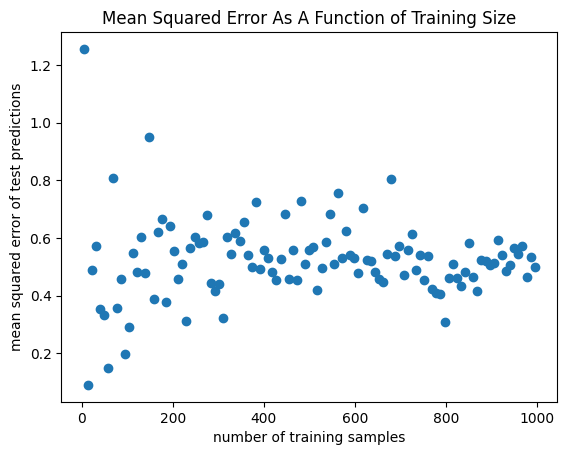

In [101]:
plt.scatter( train_sizes, errors )
plt.xlabel("number of training samples")
plt.ylabel("mean squared error of test predictions")
plt.title("Mean Squared Error As A Function of Training Size")